In [ ]:
!pip install transformers
!pip install sentencepiece

In [ ]:
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW, AlbertTokenizer, AlbertConfig, AlbertModel
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR

In [ ]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data.head(4)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...


In [ ]:
data['content'] = data.Title + ' ' + data.Description
labels = data["Class Index"]

In [ ]:
test['content'] = test.Title + ' ' + test.Description
test_labels = test['Class Index']

In [ ]:
train = data.copy()

In [ ]:
train['Class Index'].unique()

array([3, 4, 2, 1])

In [ ]:
train['Class Index'] = train['Class Index'].astype('str')

In [ ]:
test['Class Index'] = test['Class Index'].astype('str')

In [ ]:
for i in list(train['Class Index'].unique()):
    train[i] = train['Class Index'].apply(lambda x: 1 if i in x else 0)
    test[i] = test['Class Index'].apply(lambda x: 1 if i in x else 0)

In [ ]:
train

,Class Index,Title,Description,content,3,4,2,1
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...,1,0,0,0
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...,1,0,0,0
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...,1,0,0,0
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...,1,0,0,0
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new...",1,0,0,0
...,...,...,...,...,...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,Pakistan's Musharraf Says Won't Quit as Army C...,0,0,0,1
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,Renteria signing a top-shelf deal Red Sox gene...,0,0,1,0
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,Saban not going to Dolphins yet The Miami Dolp...,0,0,1,0
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,Today's NFL games PITTSBURGH at NY GIANTS Time...,0,0,1,0


In [ ]:
train.drop(['Description', 'Title', 'Class Index'], axis=1, inplace=True)
test.drop(['Description', 'Title', 'Class Index'], axis=1, inplace=True)

In [ ]:
train

,content,3,4,2,1
0,Wall St. Bears Claw Back Into the Black (Reute...,1,0,0,0
1,Carlyle Looks Toward Commercial Aerospace (Reu...,1,0,0,0
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,1,0,0,0
3,Iraq Halts Oil Exports from Main Southern Pipe...,1,0,0,0
4,"Oil prices soar to all-time record, posing new...",1,0,0,0
...,...,...,...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0,0,0,1
119996,Renteria signing a top-shelf deal Red Sox gene...,0,0,1,0
119997,Saban not going to Dolphins yet The Miami Dolp...,0,0,1,0
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,0,0,1,0


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 2
LEARNING_RATE = 2e-5
# tokenizer = AutoTokenizer.from_pretrained('roberta-base')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
target_cols = [col for col in train.columns if col not in ['content']]
target_cols

['3', '4', '2', '1']

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.content
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
test_dataset = BERTDataset(test, tokenizer, MAX_LEN)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=2, shuffle=True)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        # self.roberta = AutoModel.from_pretrained('xlm-roberta-base')
        # self.roberta = AutoModel.from_pretrained('roberta-base')
        self.bert = AutoModel.from_pretrained('bert-base-uncased')
        # self.albert = AlbertModel.from_pretrained('')
        self.l2 = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768,4)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        # _, features = self.albert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = self.fc(features)
        return output

model = BERTClass()
model.to(device);

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)
# scheduler = ExponentialLR(optimizer, gamma=0.6)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train(epoch):
    model.train()
    for _,data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        if _%1000 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Эксперимент 1

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.7327573895454407
Epoch: 0, Loss:  0.1333671659231186
Epoch: 0, Loss:  0.09098049998283386
Epoch: 0, Loss:  0.15272513031959534
Epoch: 1, Loss:  0.018405262380838394
Epoch: 1, Loss:  0.027419935911893845
Epoch: 1, Loss:  0.18930058181285858
Epoch: 1, Loss:  0.13806279003620148
Epoch: 2, Loss:  0.12231273949146271
Epoch: 2, Loss:  0.042703643441200256
Epoch: 2, Loss:  0.057309769093990326
Epoch: 2, Loss:  0.1179501861333847


Эксперимент 2

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 3
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.7169560194015503
Epoch: 0, Loss:  0.05807182937860489
Epoch: 1, Loss:  0.02691790834069252
Epoch: 1, Loss:  0.030005445703864098
Epoch: 2, Loss:  0.10249627381563187
Epoch: 2, Loss:  0.07954226434230804


KeyboardInterrupt: ignored

3. Эксперимент bert

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 2
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
    train(epoch)
    # scheduler1.step()
    # scheduler2.step()

Epoch: 0, Loss:  0.6746780872344971
Epoch: 0, Loss:  0.046245090663433075
Epoch: 1, Loss:  0.025209346786141396
Epoch: 1, Loss:  0.060384899377822876


In [ ]:
def test():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

Эксперимент 1

In [ ]:
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
f1_score_weighted = metrics.f1_score(targets, outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.9363157894736842
F1 Score (Micro) = 0.9400976382108458
F1 Score (Macro) = 0.9398604848538293
F1 Score (Weighted) = 0.9398604848538293


Эксперимент 2

In [ ]:
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
f1_score_weighted = metrics.f1_score(targets, outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.9435526315789474
F1 Score (Micro) = 0.946127502634352
F1 Score (Macro) = 0.9460851255149583
F1 Score (Weighted) = 0.9460851255149583


Эксперимент bert

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =64
# EPOCHS = 2
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.945
F1 Score (Micro) = 0.9479166666666667
F1 Score (Macro) = 0.9478178698229659


In [ ]:
cols = [3, 4, 2, 1]
new_outputs = []
count = 0
for each in outputs:
  count += 1
  if (not each[0] and not each[1] and  not each[2] and  not each[3]):
    i = random.randrange(len(cols))
    new_outputs.append(cols[i])
    continue 
  for i in range(4):
    if(each[i]):
      new_outputs.append(cols[i])
      break

Эксперимент 1

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

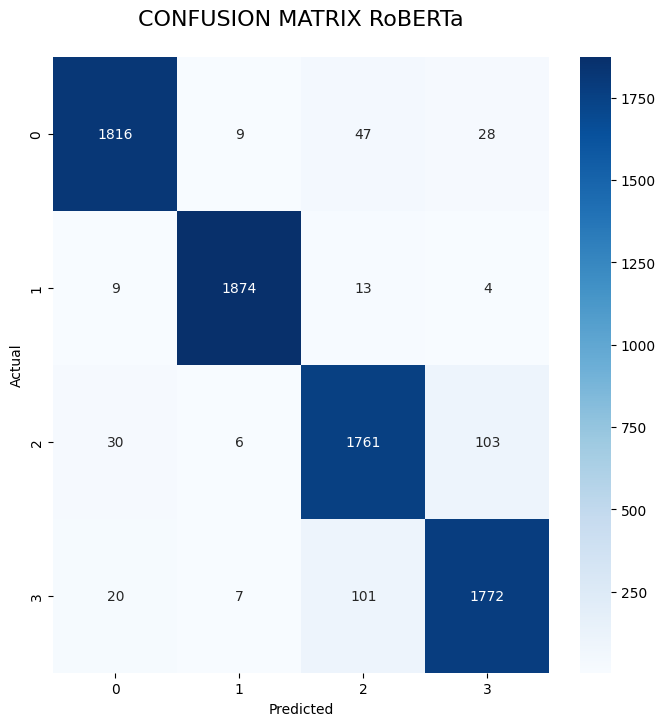

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 2

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

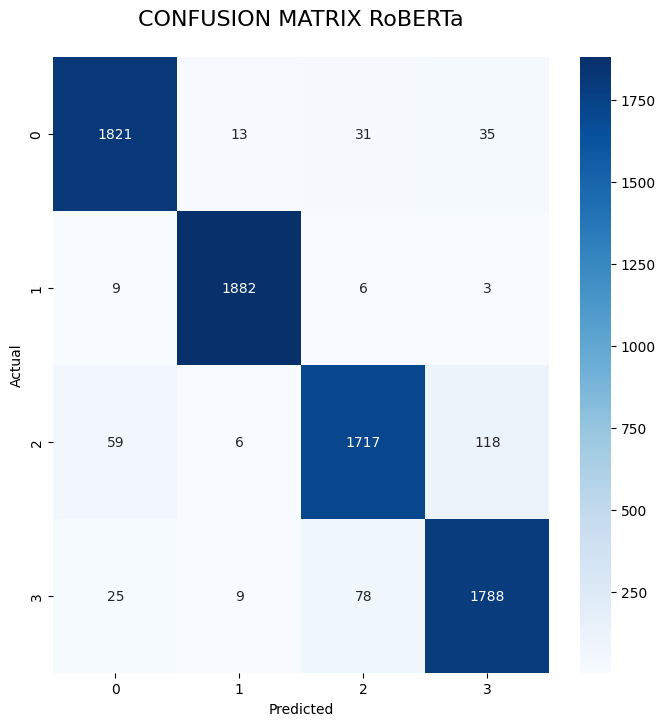

In [ ]:
# MAX_LEN = 200
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 3

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

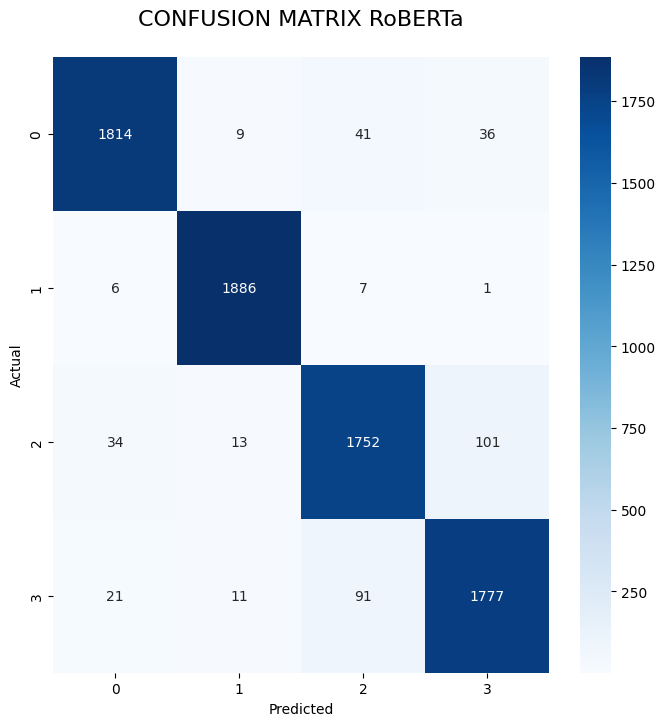

In [ ]:
# MAX_LEN = 100
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 4

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

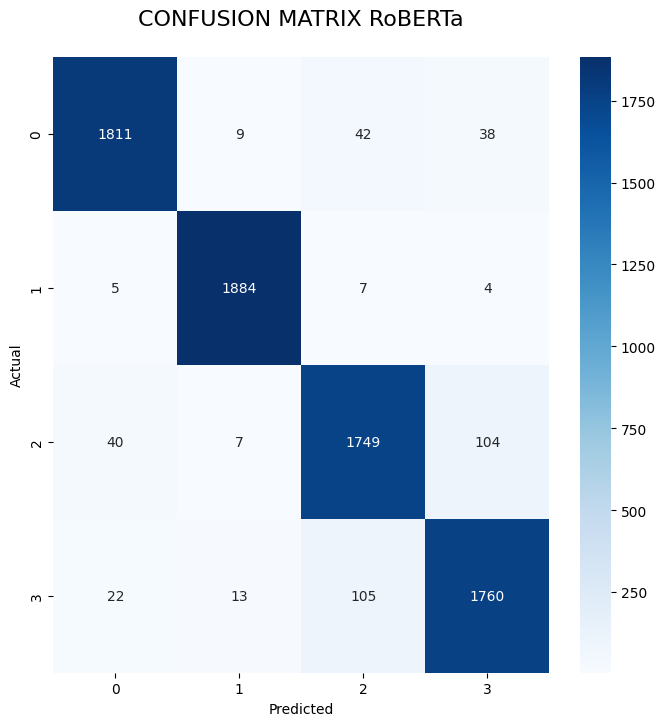

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 16
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 5

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

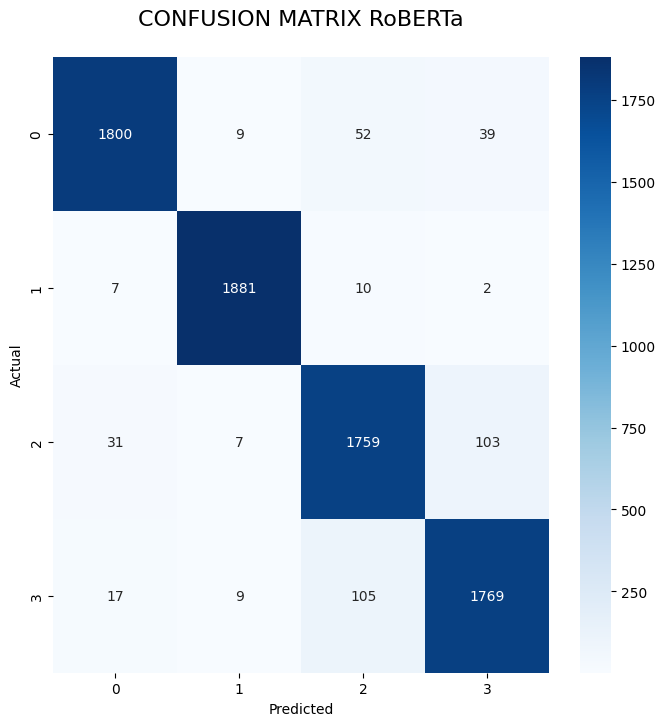

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 6

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

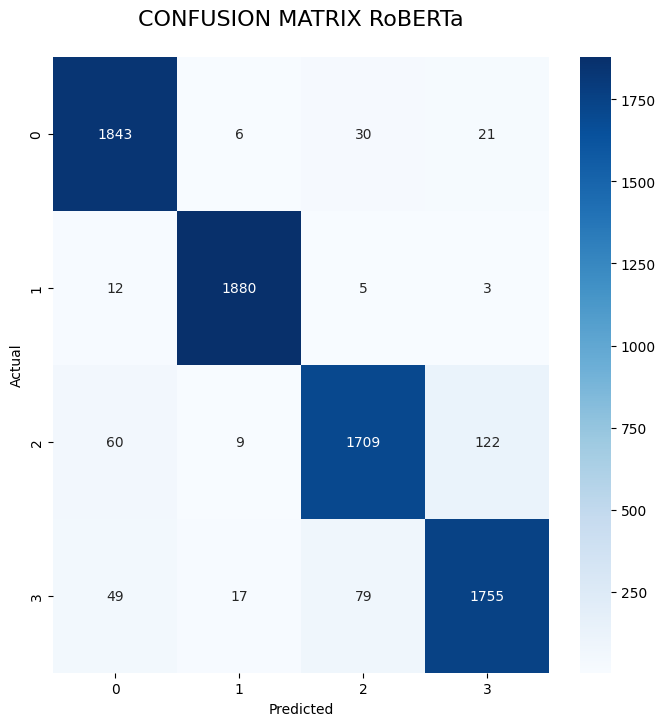

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 5
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 7

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

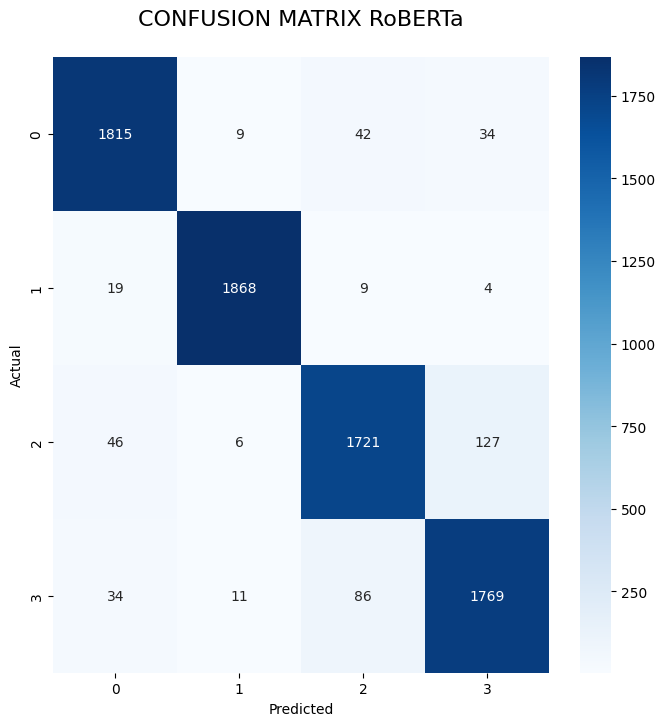

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 2
# LEARNING_RATE = 2e-6
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент №10 roberta-xlm

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

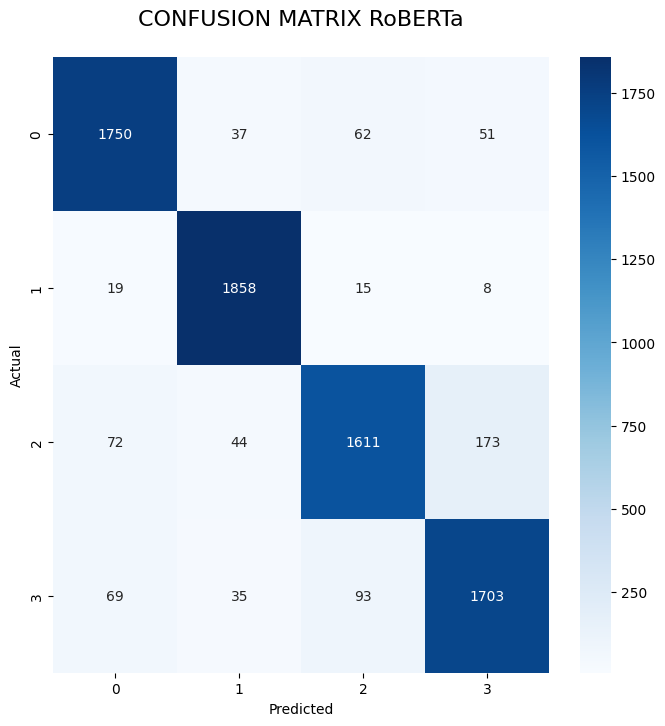

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 4
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 11 роберта+scheduler


Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

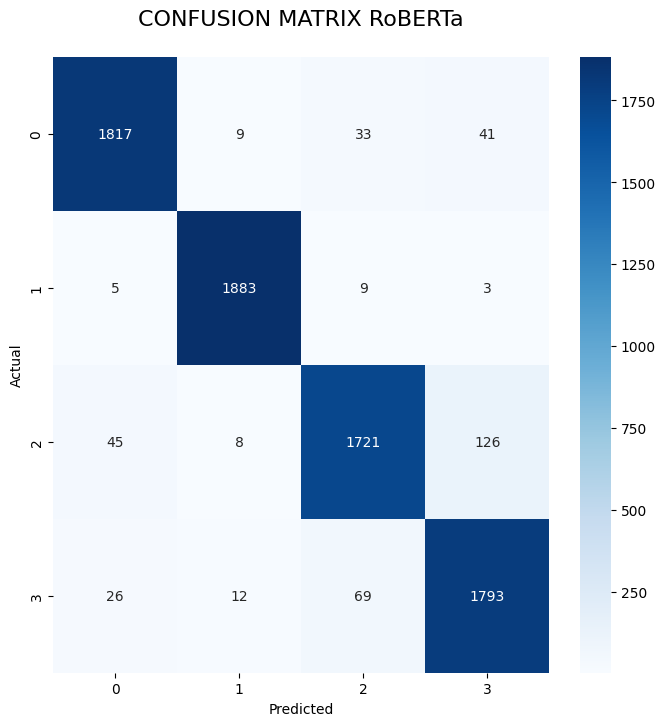

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 4
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 13 роберта+scheduler (gamma=0.6)

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

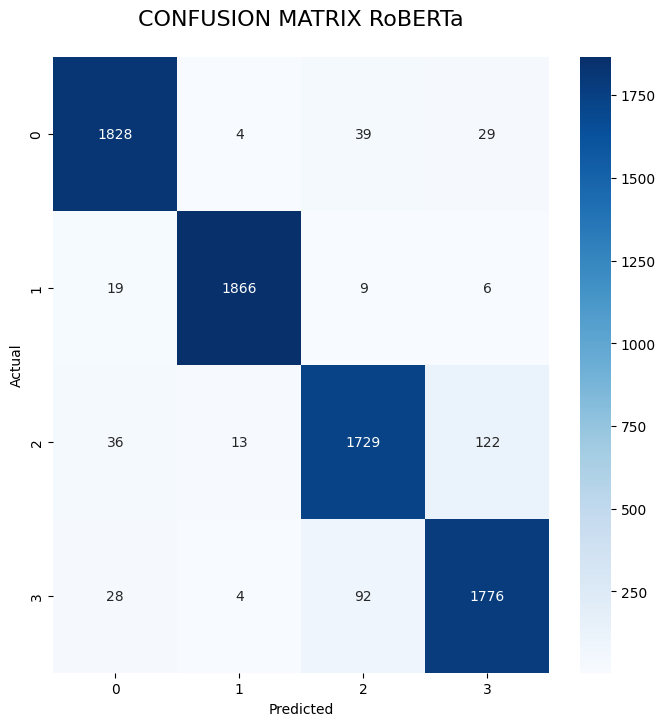

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 4
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 14 роберта+ 2 scheduler-a (gamma=0.9 и MultiStepLR(optimizer, milestones=[30,80], gamma=0.1))

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 4
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

2 Эксперимент БЕРТ

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

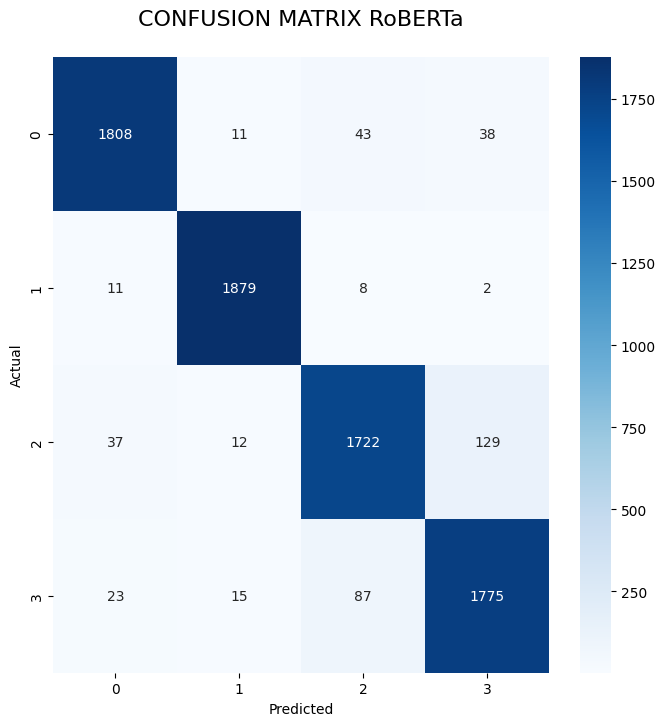

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

In [ ]:
def saveModel():
    path = "./bert_AG_128_2_64_2e-5.pth"
    torch.save(model.state_dict(), path)

In [ ]:
saveModel()

In [ ]:
def test_model_by_train():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(train_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [34]:
train_outputs, train_targets = test_model_by_train()
train_outputs = np.array(train_outputs) >= 0.5
accuracy = metrics.accuracy_score(train_targets, train_outputs)
f1_score_micro = metrics.f1_score(train_targets, train_outputs, average='micro')
f1_score_macro = metrics.f1_score(train_targets, train_outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9715666666666667
F1 Score (Micro) = 0.97348623853211
F1 Score (Macro) = 0.9734623854587322


In [38]:
new_targets = []
for each in train_targets:
  tar = []
  tar.append(int(each[0] * 3))
  tar.append(int(each[1] * 4))
  tar.append(int(each[2] * 2))
  tar.append(int(each[3] * 1))
  new_targets.append(max(tar))

In [44]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=0.5, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_outputs, new_targets)

LinearSVC(C=0.5, class_weight='balanced', max_iter=100000, random_state=42)

In [45]:
test_outputs, test_targets = test()
y_pred = clf.predict(test_outputs)

In [47]:
new_targets = []
for each in test_targets:
  tar = []
  tar.append(int(each[0] * 3))
  tar.append(int(each[1] * 4))
  tar.append(int(each[2] * 2))
  tar.append(int(each[3] * 1))
  new_targets.append(max(tar))

In [50]:
accuracy = metrics.accuracy_score(new_targets, y_pred)
f1_score_micro = metrics.f1_score(new_targets, y_pred, average='micro')
f1_score_macro = metrics.f1_score(new_targets, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9481578947368421
F1 Score (Micro) = 0.9481578947368421
F1 Score (Macro) = 0.9480885203210786
